In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from PreprocessModule import is_defrost
from VisualizeModule import draw_lineplot
import json

plt.rcParams['font.family'] = "Malgun Gothic"

# 01. 데이터 불러오기

In [2]:
with open("../data/test_result_data.json") as f:
    test_result_data = json.load(f)

# 02. 시각화할 데이터 선정하기

## 1) 이미지 변환 방식에 따른 평균 LOSS 비교하기

In [3]:
for feature in test_result_data.keys():
    loss = []
    word = "공급온도"
    for key, val in test_result_data[feature].items():
        loss.append(val[1][0])

    if feature[:4] == "gasf":
        if feature[5:] == "at":
            word = "외부온도"
        elif feature[5:] == "rat":
            word = "순환온도"
        print(f"GASF방식으로 전처리한 {word}의 테스트셋 MSE 평균: {np.mean(loss):.4f}")

    if feature[:4] == "gadf":
        if feature[5:] == "at":
            word = "외부온도"
        elif feature[5:] == "rat":
            word = "순환온도"
        print(f"GADF방식으로 전처리한 {word}의 테스트셋 MSE 평균: {np.mean(loss):.4f}")

GASF방식으로 전처리한 외부온도의 테스트셋 MSE 평균: 0.4480
GASF방식으로 전처리한 순환온도의 테스트셋 MSE 평균: 0.3100
GASF방식으로 전처리한 공급온도의 테스트셋 MSE 평균: 0.3692
GADF방식으로 전처리한 외부온도의 테스트셋 MSE 평균: 0.2341
GADF방식으로 전처리한 순환온도의 테스트셋 MSE 평균: 0.2056
GADF방식으로 전처리한 공급온도의 테스트셋 MSE 평균: 0.2104


###  1)의 결론
- GADF의 변환 방식을 적용했을 때, LOSS가 더 작았으므로 GADF로 변환한 방식의 데이터만 분석하도록 한다.

## 2) GADF 변환 방식의 LOSS 모두 더하기

In [4]:
loss_gadf = []

for key in list(test_result_data.keys())[3:]:
    loss = [x[1][0] for key, x in test_result_data[key].items()]
    idx = [x[1][1][0] for key, x in test_result_data[key].items()]
    reefer = [x[1][1][1] for key, x in test_result_data[key].items()]

    loss_gadf.append(np.array(loss))

In [5]:
loss_sum = list(loss_gadf[0] + loss_gadf[1] + loss_gadf[2])

## 3) LOSS와 데이터의 인덱스, 컨테이너 ID 값을 데이터 프레임으로 만들기

In [6]:
loss_idx_reefer_id = pd.DataFrame({"loss":loss_sum, "index_list":idx, "reefer_id":reefer})

In [7]:
loss_idx_reefer_id.head()

,loss,index_list,reefer_id
0,0.451842,"[5225, 5226, 5227, 5228, 5229, 5230, 5231, 523...",BMOU9003717
1,0.678229,"[5502, 5503, 5504, 5505, 5506, 5507, 5508, 550...",BMOU9003717
2,0.533754,"[19211, 19212, 19213, 19214, 19215, 19216, 192...",BMOU9003717
3,0.716789,"[26691, 26692, 26693, 26694, 26695, 26696, 266...",RJCU6995820
4,0.690007,"[21156, 21157, 21158, 21159, 21160, 21161, 211...",RJCU6995820


# 03. GADF 방식으로 변환한 테스트셋의 MSE 분포 시각화하기

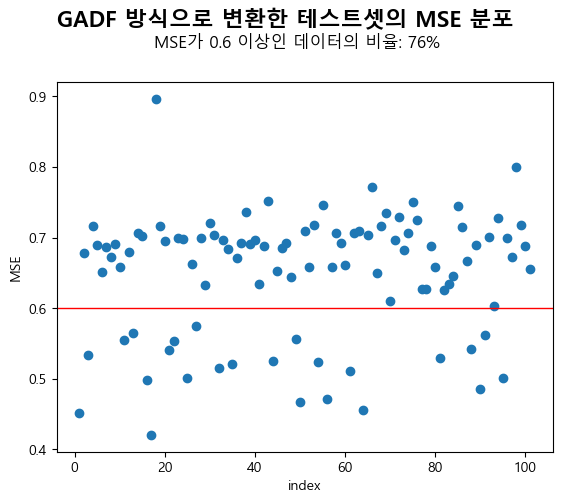

In [8]:
# 임계값은 0.6 이므로 0.6을 기준으로 데이터 분리
above_06_index = [idx for idx, x in enumerate(loss_sum) if x > 0.6]
bellow_06_index = [idx for idx, x in enumerate(loss_sum) if x <= 0.6]

precent = int((len(above_06_index) / len(loss_sum)) * 100)

plt.scatter(x=range(1, len(loss_sum)+1), y=loss_sum)
plt.axhline(y=0.6, color='r', linewidth=1)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('GADF 방식으로 변환한 테스트셋의 MSE 분포', fontdict=title_font, loc='left', pad=40)
plt.suptitle(f'MSE가 0.6 이상인 데이터의 비율: {precent}%')
plt.ylabel("MSE")
plt.xlabel("index");

### 시각화 결과
- 0.6을 기준으로 데이터가 분리되는 양상이 보인다.
- 올바르게 분리가 되었는지 확인하기 위해서는 0.6 부근의 정상과 비정상 데이터를 시각화하여 패턴에 차이가 있는지 확인해볼 필요가 있다.

# 04. LOSS가 0.6 부근에 위치한 데이터 비교

In [9]:
# 시각화를 위해 원본 데이터 불러오기
df = pd.read_csv('../data/carrier_reefer_data_01_to_08_and_12.csv')

In [10]:
# 문자열을 datetime으로 변경
df['when_created'] = df['when_created'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [11]:
# 0.6을 기준으로 데이터 분리
bellow_06_df = loss_idx_reefer_id.iloc[bellow_06_index]
above_06_df = loss_idx_reefer_id.iloc[above_06_index]

In [12]:
# 정상인 것중에 loss가 가장 높은 데이터 추출
bellow_06_max = bellow_06_df.loc[bellow_06_df['loss'].idxmax()]

# 비정상인 것중에 loss가 가장 낮은 데이터 추출
above_06_min = above_06_df.loc[above_06_df['loss'].idxmin()]

## 1) 0.6 부근의 정상 데이터와 비정상 데이터 추출
- loss가 0.6 이하인 정상 데이터 중 loss 값이 가장 높은 데이터 추출
- loss가 0.6 초과인 비정상 데이터 중 loss 값이 가장 낮은 데이터 추출

In [13]:
df_bellow_06_max = df.loc[df['reefer_id'] == bellow_06_max['reefer_id']].iloc[bellow_06_max['index_list']]
df_above_06_min = df.loc[df['reefer_id'] == above_06_min['reefer_id']].iloc[above_06_min['index_list']]

## 2) 시각화를 위한 전처리 진행
- DEFROST를 시각화하기 위해 IS_DEFROST 컬럼 생성
- x축에 시간을 표시하기 위해 데이터의 인덱스를 timeseries로 설정

In [14]:
# IS_DEFROST 컬럼 생성
df_bellow_06_max['IS_DEFROST'] = df_bellow_06_max.apply(lambda x:is_defrost(x['return_air_temperature'], x['operating_mode_str']), axis=1)
df_above_06_min['IS_DEFROST'] = df_above_06_min.apply(lambda x:is_defrost(x['return_air_temperature'], x['operating_mode_str']), axis=1)

In [15]:
# 날짜를 인덱스로 설정
df_bellow_06_max = df_bellow_06_max.set_index('when_created')
df_above_06_min = df_above_06_min.set_index('when_created')

## 3) 두 데이터 시각화

<Figure size 640x480 with 0 Axes>

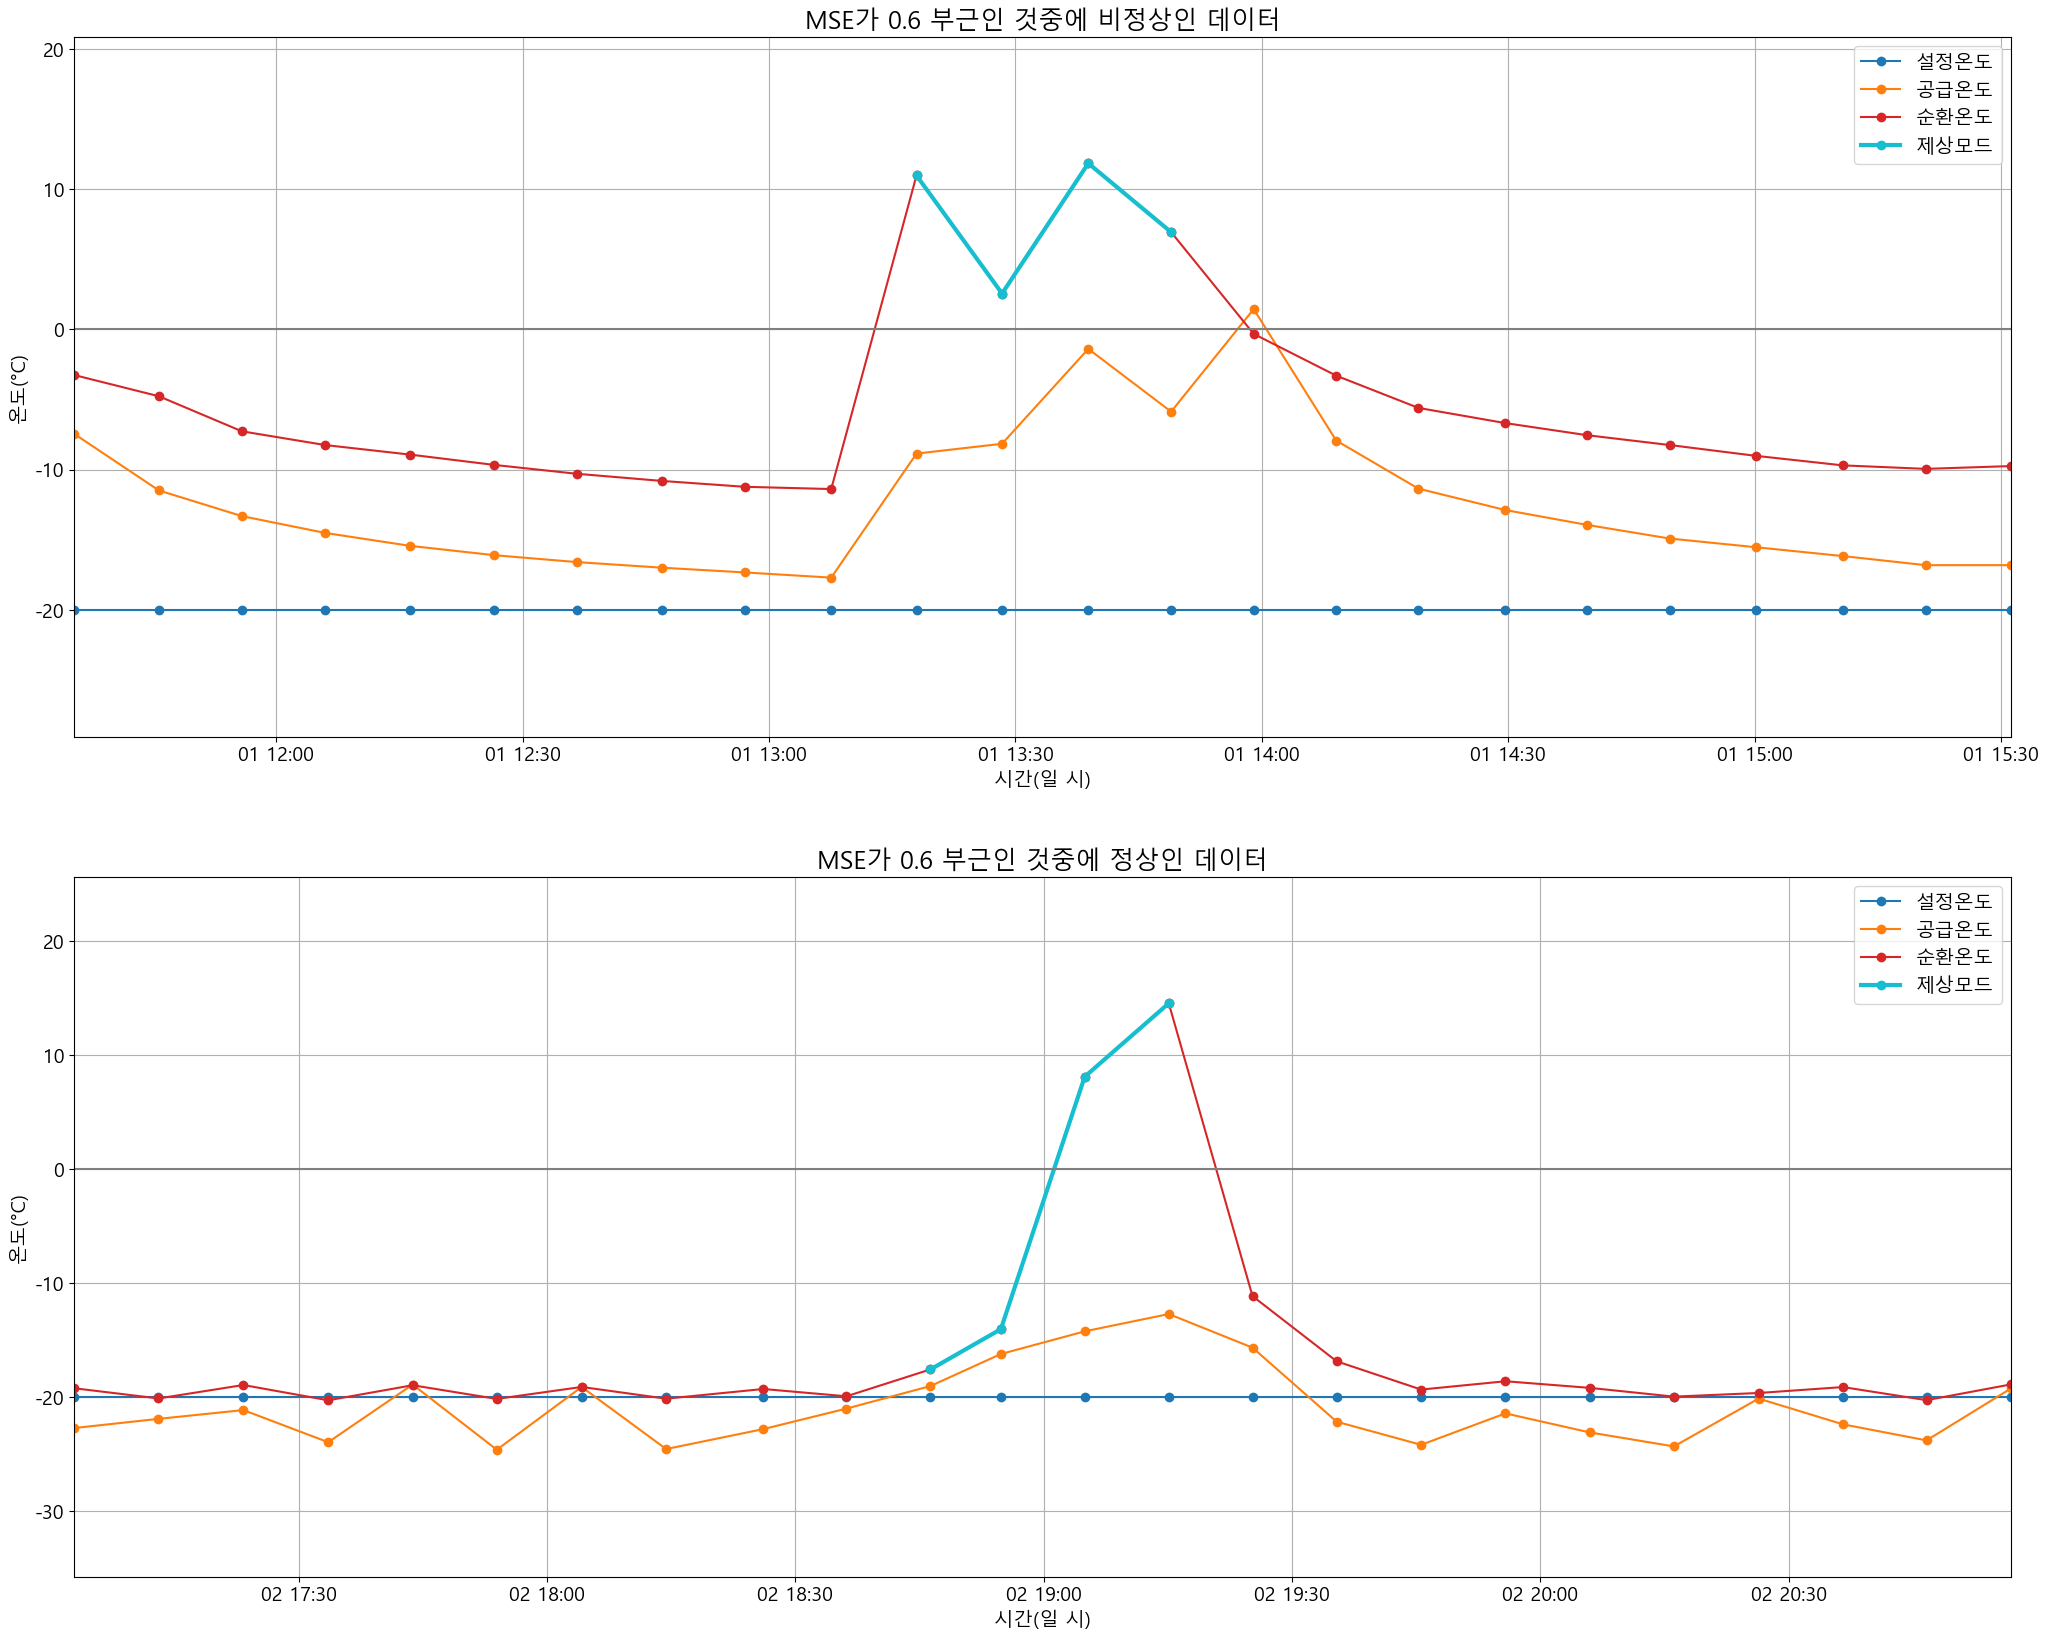

In [16]:
draw_lineplot([df_bellow_06_max, df_above_06_min], ["MSE가 0.6 부근인 것중에 비정상인 데이터", "MSE가 0.6 부근인 것중에 정상인 데이터"])

### 시각화 결과
- 정상과 비정상 데이터 모두 0.6 부근에 위치하고 있으나, 두 패턴에 차이가 존재한다.
- 정상 데이터의 경우는 평범한 정상 패턴이 보이고, 비정상 데이터의 경우 온도가 올바르게 정착하지 못하는 이상 패턴으로 나타난다.